## Run the Docker Container for Neo4j
```
docker run \
    --publish=7474:7474 --publish=7687:7687 \
    --env='NEO4JLABS_PLUGINS=["apoc"]' \
    --env='NEO4J_AUTH=neo4j/qwerty12' \
    neo4j
```

In [1]:
def valid_property_to_include_all_in_query(node_props):
    # Check if node_props is an empty dictionary
    if not node_props:
        return node_props
    
    cleaned_props = "{"
    
    # Remove single quotes from keys and values
    for key, value in node_props.items():
        cleaned_props += str(key) + ":"
        if isinstance(value, str):
            # couldnot escape 'US BANCORP \\DE\\' and users'
            cleaned_props += "'" + value.replace("\\", "").replace("'", r"\'") + "'"
        else:
            cleaned_props += str(value)
        cleaned_props += ","
    
    # Remove the last comma and add closing curly brace
    cleaned_props = cleaned_props[:-1] + "}"
    return cleaned_props


In [2]:
import os
import json

from neo4j import GraphDatabase
from dotenv import load_dotenv

# Load dotenv
load_dotenv()

NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_DATABASE = os.getenv("NEO4J_DATABASE")

# Load data from JSON file
with open('./data/exported_data.json', 'r') as f:
    export_data = json.load(f)

# Connect to the new Neo4j database
new_driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

# Define the query template for creating relationship nodes
QUERY_CREATE_RELATION_NODE = """
MERGE (source:{start_node_label} {start_node_props})-[r:{relationship_type}]->(target:{target_node_label} {target_node_props})
// WHERE ID(source) = $source_id AND ID(target) = $target_id
SET r += {relationship_props}
"""
QUERY_CREATE_RELATION_NODE = """
MATCH (source:{start_node_label} {start_node_props}), (target:{target_node_label} {target_node_props})
WHERE source.id = {source_id} AND source.id = {target_id}
CREATE (source)-[r:{relationship_type}]->(target)
SET r += {relationship_props}
"""

QUERY_CREATE_RELATION_NODE = """
MATCH (source:{start_node_label}), (target:{target_node_label})
WHERE source.id = {source_id} AND target.id = {target_id}
MERGE (source)-[r:{relationship_type}]->(target)
SET r += {relationship_props}
"""

# Iterate through the exported data
for record in export_data:
    try:
        if "lonely_node" in record:
            node_data = record["lonely_node"]
            # Pop label name from node data
            label = node_data.pop("label")

            with new_driver.session() as session:
                match_query = f"MERGE (n:{label[0]} {valid_property_to_include_all_in_query(node_data)}) RETURN n"
                session.run(query, props=node_data)
            continue

        # Retrieve start and end nodes along with relationship data
        start_node = record['start_node']
        start_node_label = start_node.pop('label')
        relationship_data = record['relationship']
        end_node = record['end_node']
        target_node_label = end_node.pop('label')

        # Write node with relationship
        with new_driver.session() as session:
            # first create start node
            first_query = f"MERGE (n:{start_node_label[0]} {valid_property_to_include_all_in_query(start_node)}) RETURN n"
            session.run(first_query)

            # create last node
            end_node_query = f"MERGE (n:{target_node_label[0]} {valid_property_to_include_all_in_query(end_node)}) RETURN n"
            session.run(end_node_query)

            # get source id and target id
            source_id = start_node.pop("id")
            target_id = end_node.pop('id')

            # # test the validaity
            # query = f"""
            #     MATCH (source:{start_node_label[0]}), (target:{target_node_label[0]})
            #     WHERE source.id = {source_id} AND target.id = {target_id}
            #     return source, target
            #     """.format()
            # query = make_valid_query(query=query)
            # print(query)
            # reuslt = session.run(query)
            # # print result
            # print(reuslt.single())
            # break

            query = QUERY_CREATE_RELATION_NODE.format(
                start_node_label=start_node_label[0],
                source_id=source_id,
                relationship_type=relationship_data["type"], 
                target_node_label=target_node_label[0],
                # start_node_props=start_node,
                relationship_props=valid_property_to_include_all_in_query(relationship_data["property"]),
                # target_node_props=end_node,
                target_id=target_id
            )
            session.run(query)

    except Exception as err:
        print(f"[ERROR]: {err}")
        print("-" * 100)
        break

# # Close the new driver
# new_driver.close()


In [3]:
start_node

{'cusip': 'G06242104',
 'names': ['ATLASSIAN CORP PLC', 'ATLASSIAN CORPORATION PLC'],
 'companyAddress': '431 El Camino Real, Santa Clara, CA 95050, USA',
 'companyName': 'ATLASSIAN CORP PLC',
 'cusip6': 'G06242',
 'location': [-121.9323029, 37.3473759]}

In [4]:
valid_property_to_include_all_in_query(start_node)

"{cusip:'G06242104',names:['ATLASSIAN CORP PLC', 'ATLASSIAN CORPORATION PLC'],companyAddress:'431 El Camino Real, Santa Clara, CA 95050, USA',companyName:'ATLASSIAN CORP PLC',cusip6:'G06242',location:[-121.9323029, 37.3473759]}"

In [5]:
def valid_property_to_include_all_in_query(node_props):
    # Check if node_props is an empty dictionary
    if not node_props:
        return node_props
    
    cleaned_props = "{"
    
    # Remove single quotes from keys and values
    for key, value in node_props.items():
        cleaned_props += str(key) + ":"
        if isinstance(value, str):
            cleaned_props += "'" + value.replace("\\", "").replace("'", r"\'") + "'"
        else:
            cleaned_props += str(value)
        cleaned_props += ","
    
    # Remove the last comma and add closing curly brace
    cleaned_props = cleaned_props[:-1] + "}"
    return cleaned_props

cleaned_dict = valid_property_to_include_all_in_query(start_node)
cleaned_dict

"{cusip:'G06242104',names:['ATLASSIAN CORP PLC', 'ATLASSIAN CORPORATION PLC'],companyAddress:'431 El Camino Real, Santa Clara, CA 95050, USA',companyName:'ATLASSIAN CORP PLC',cusip6:'G06242',location:[-121.9323029, 37.3473759]}"

In [6]:
f"MERGE (n:{target_node_label[0]} {valid_property_to_include_all_in_query(start_node)}) RETURN n"

"MERGE (n:Address {cusip:'G06242104',names:['ATLASSIAN CORP PLC', 'ATLASSIAN CORPORATION PLC'],companyAddress:'431 El Camino Real, Santa Clara, CA 95050, USA',companyName:'ATLASSIAN CORP PLC',cusip6:'G06242',location:[-121.9323029, 37.3473759]}) RETURN n"

In [7]:
with new_driver.session() as session:
    # first create start node
    first_query = f"MERGE (n:{start_node_label[0]} {valid_property_to_include_all_in_query(start_node)}) RETURN n"
    # first_query = "MERGE (n:Manager {managerCik:'36104',managerAddress:'U.S. BANCORP, 800 NICOLLET MALL, MINNEAPOLIS, MN, 55402-7020',location:[-93.2738748, 44.9755906],managerName:'US BANCORP \DE\',id:3042}) RETURN n"
    session.run(first_query)

In [8]:
valid_property_to_include_all_in_query(end_node)

"{country:'United States',city:'Santa Clara',location:[-121.9323029, 37.3473759],state:'California'}"

In [9]:
print("=====START NODE=====\n", start_node)
print("=====END NODE=====\n", end_node)

=====START NODE=====
 {'cusip': 'G06242104', 'names': ['ATLASSIAN CORP PLC', 'ATLASSIAN CORPORATION PLC'], 'companyAddress': '431 El Camino Real, Santa Clara, CA 95050, USA', 'companyName': 'ATLASSIAN CORP PLC', 'cusip6': 'G06242', 'location': [-121.9323029, 37.3473759]}
=====END NODE=====
 {'country': 'United States', 'city': 'Santa Clara', 'location': [-121.9323029, 37.3473759], 'state': 'California'}


In [10]:
query = QUERY_CREATE_RELATION_NODE.format(
                start_node_label=start_node_label[0],
                source_id=source_id,
                relationship_type=relationship_data["type"], 
                target_node_label=target_node_label[0],
                # start_node_props=start_node,
                relationship_props=relationship_data["property"],
                # target_node_props=end_node,
                target_id=target_id
            )

In [11]:
record = export_data[2]

### Final Database 
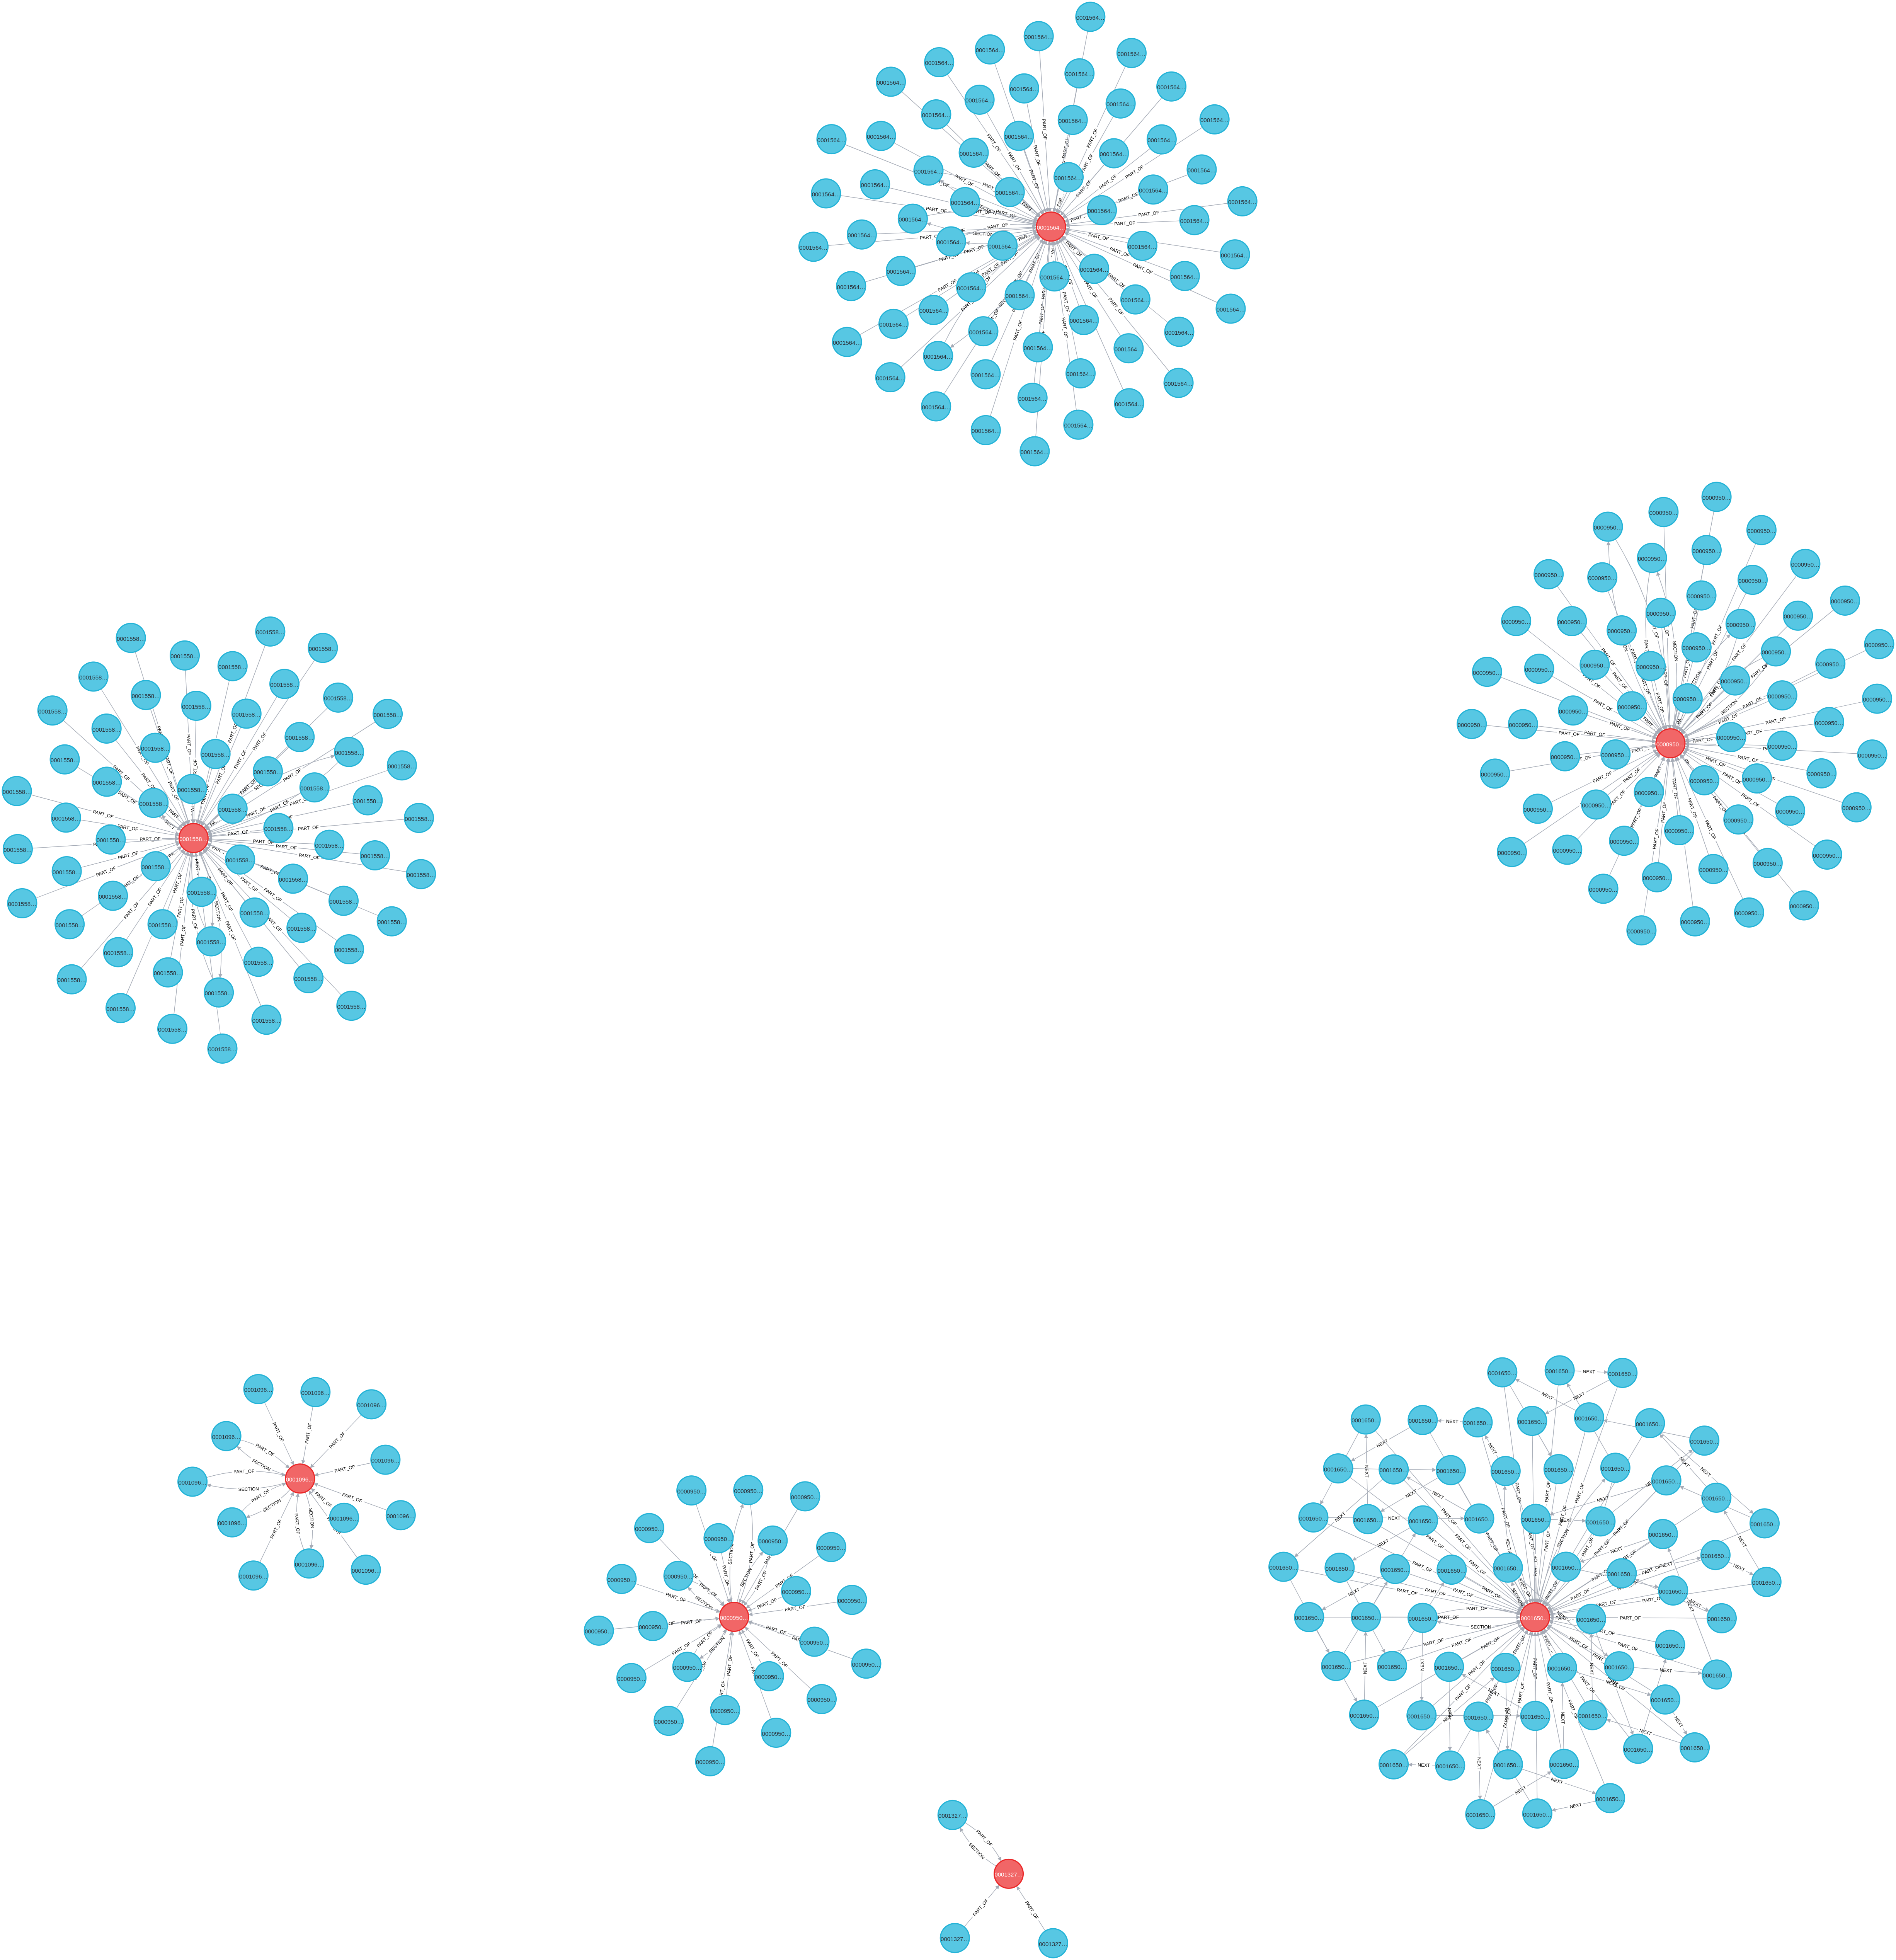